# Welcome to pystardog

This notebook demonstrates many of the features of pystardog interactively. Select `Kernel` -> `Restart & Run All` in the menu to run all the cells in this notebook and view the output.

**Warning:** if you have a database named `pystardog-tutorial` on your server, it will be dropped and recreated by this notebook. You can change the name of the database for this tutorial in the cell below this one.

In [1]:
database_name = 'pystardog-tutorial'

## Table of contents

- [Server administration](#Admininstrative-actions-on-the-server)
 - [databases](#Databases)
 - [stored queries](#Stored-Queries)
 - [virtual graphs](#Virtual-Graphs)
- Database connections

## Dependencies

The following libraries are used:

- pandas: [Data Analysis Library](https://pandas.pydata.org/)
- seaborn: [Statistical Data Visualization](https://seaborn.pydata.org/)

The following files are used to populate the database with sample data. They should be located in the same directory as this notebook.

- [music schema](https://github.com/stardog-union/stardog-tutorials/raw/master/music/music_schema.ttl)
- [music data](https://github.com/stardog-union/stardog-tutorials/raw/master/music/music.ttl.gz)

In [1]:
import io
import stardog
import pandas as pd
import seaborn as sns

# Specify Stardog connection details
connection_details = {
  'endpoint': 'http://localhost:5820',
  'username': 'admin',
  'password': 'admin'
}

## Admininstrative actions on the server

[Admin](https://pystardog.readthedocs.io/en/latest/source/stardog.html#module-stardog.admin) instances are used to administer the server.

In [1]:
admin = stardog.Admin(**connection_details)

### Databases

[Database](https://pystardog.readthedocs.io/en/latest/source/stardog.html#stardog.admin.Database) instances administer a single database.

#### Retrieve a list of databases
[docs](https://pystardog.readthedocs.io/en/latest/source/stardog.html#stardog.admin.Admin.databases)

In [1]:
# output will likely vary on your system
[db.name for db in admin.databases()]

['test', 'pystardog-tutorial']

#### Drop a database

[docs](https://pystardog.readthedocs.io/en/latest/source/stardog.html#stardog.admin.Database.drop)

In [1]:
if database_name in [db.name for db in admin.databases()]:
    admin.database(database_name).drop()

#### Create a new database

Configuration parameters can be easily set while creating the database.

[docs](https://pystardog.readthedocs.io/en/latest/source/stardog.html#stardog.admin.Admin.new_database)

In [1]:
db = admin.new_database(database_name, {'search.enabled': True})

#### Get a  database instance

[docs](https://pystardog.readthedocs.io/en/latest/source/stardog.html#stardog.admin.Admin.database)

In [1]:
db = admin.database(database_name)

#### Get options
[docs](https://pystardog.readthedocs.io/en/latest/source/stardog.html#stardog.admin.Database.get_options)

In [1]:
db.get_options('search.enabled', 'spatial.enabled')

{'spatial.enabled': False, 'search.enabled': True}

#### Set options
[docs](https://pystardog.readthedocs.io/en/latest/source/stardog.html#stardog.admin.Database.set_options)

In [1]:
db.offline() # the database must be offline to change some options
db.set_options({'spatial.enabled': False})
db.online()

### Stored Queries

[StoredQuery](https://pystardog.readthedocs.io/en/latest/source/stardog.html#stardog.admin.StoredQuery) instances manage stored queries on the server.

#### Create a new stored query

In [1]:
admin.new_stored_query(
    'all_triples',
    'select * where { ?s ?p ?o . }',
    { 'database': database_name }
)

#### List stored queries
[docs](https://pystardog.readthedocs.io/en/latest/source/stardog.html#stardog.admin.Admin.stored_queries)

In [1]:
[sq.name for sq in admin.stored_queries()]

['all_triples']

#### Get a stored query
[docs](https://pystardog.readthedocs.io/en/latest/source/stardog.html#stardog.admin.Admin.stored_query)

In [1]:
sq = admin.stored_query('all_triples')

#### Delete a stored query
[docs](https://pystardog.readthedocs.io/en/latest/source/stardog.html#stardog.admin.StoredQuery.delete)

In [1]:
sq.delete()

### Virtual Graphs
[Stardog documentation](https://docs.stardog.com/virtual-graph)

[VirtualGraph](https://pystardog.readthedocs.io/en/latest/source/stardog.html#stardog.admin.VirtualGraph) instances manage virtual graphs on the server.

#### Create a new virtual graph
[docs](https://pystardog.readthedocs.io/en/latest/source/stardog.html#stardog.admin.Admin.new_virtual_graph)

In [1]:
example_vg_options = {
        "jdbc.driver": "com.mysql.jdbc.Driver",
        "jdbc.username": "admin",
        "jdbc.password": "admin",
        "jdbc.url": "jdbc:mysql://localhost/my_db"
}

#admin.new_virtual_graph('vg', content.File('path/to/mapping_file.ttl'), example_vg_options)

## Connections to Stardog databases

[Connection](https://pystardog.readthedocs.io/en/latest/source/stardog.html#module-stardog.connection) instances are used for all user-related operations on a Stardog database.

In [1]:
conn = stardog.Connection(database_name, **connection_details)

### Transactions
#### Start a transaction

In [1]:
conn.begin()

'1bd9e714-f595-4719-b667-2d53c7e2b025'

#### Add data

[docs](https://pystardog.readthedocs.io/en/latest/source/stardog.html#stardog.connection.Connection.add)

In [1]:
conn.add(stardog.content.File('music_schema.ttl'))

In [1]:
conn.add(stardog.content.File('music.ttl.gz'))

#### Commit the transaction

[docs]()

In [1]:
conn.commit() # commit the transaction
# alternately, conn.rollback() to cancel

### Query the database

This query returns the date the album was released for each album in the database.

In [1]:
query = """
SELECT ?date WHERE {
  ?s a <http://stardog.com/tutorial/Album> ;
    <http://stardog.com/tutorial/date> ?date .
}
"""

csv_results = conn.select(query, content_type=stardog.content_types.CSV)
df = pd.read_csv(io.BytesIO(csv_results))
df.head()

,date
0,1977-10-14
1,2006-01-01
2,2011-09-09
3,1988-08-25
4,1978-03-24


### Plot the number of albums released in each month

<AxesSubplot:xlabel='month', ylabel='count'>

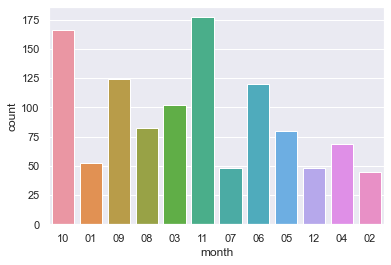

In [1]:
df['month'] = df['date'].str.split('-').str[1] #Extract the month from the dates
sns.set(style="darkgrid")
sns.countplot(x='month', data=df)

### Parameterized query

Use the bindings argument to safely parameterize a query. This example demonstrates how to pass a parameter to a  [Full-text Search](https://docs.stardog.com/query-stardog/full-text-search) query.

In [1]:
query = """prefix fts: <tag:stardog:api:search:>

SELECT ?score ?source ?class ?result WHERE {
  service fts:textMatch {
      [] fts:query ?query ;
         fts:score ?score ;
         fts:result ?result ;
  }
  ?source a ?class ;
      ?predicate ?result .
}
order by desc(?score)"""

csv_results = conn.select(query, content_type=stardog.content_types.CSV, bindings={'query': '"star AND dog"'})
df = pd.read_csv(io.BytesIO(csv_results))
pd.set_option('display.max_colwidth', None) # don't truncate when displaying the result
df

,score,source,class,result
0,11.454201,http://stardog.com/tutorial/Paul_Williams_(Songwriter),http://stardog.com/tutorial/Songwriter,"Paul Hamilton Williams, Jr. (born September 19, 1940) is an American composer, singer, Songwriter and actor. He is perhaps best known for popular songs performed by a number of acts in the 1970s including Three Dog Night's version of ""An Old Fashioned Love Song"", Helen Reddy's ""You and Me Against the World"", David Bowie's ""Fill Your Heart"", and the Carpenters' ""We've Only Just Begun"" and ""Rainy Days and Mondays"", as well as his contributions to films, such as writing the lyrics to the #1 chart-topping ""Evergreen"", the love theme from A Star Is Born, starring Barbra Streisand, for which he won a Grammy for Song of the Year and an Academy Award for Best Original Song; and ""Rainbow Connection"" from The Muppet Movie. He also wrote the lyrics to the opening theme for The Love Boat, with music p"
1,11.454201,http://stardog.com/tutorial/Josh_Kear,http://stardog.com/tutorial/Songwriter,"Josh Kear is a Nashville-based Songwriter who has become known as one of the country genre’s most consistent hit makers. He has spent nearly thirteen years writing for independent powerhouse Big Yellow Dog Music. In 2007, he had his breakthrough number one song with Carrie Underwood’s massive hit “Before He Cheats” which spent five weeks at the top of the charts. Josh recently celebrated his 11th number one song ""Drinking Class” by country star Lee Brice, , which was the most played country song of 2015 according to the Billboard country airplay chart."


### Alternate result content types

Stardog can return the results in formats besides `CSV` including `SPARQL_XML` and `SPARQL_JSON`. An example is provided below.

In [1]:
conn.select(query, content_type=stardog.content_types.SPARQL_JSON, bindings={'query': '"star AND dog"'})

{'head': {'vars': ['score', 'source', 'class', 'result']},
 'results': {'bindings': [{'result': {'type': 'literal',
     'value': 'Paul Hamilton Williams, Jr. (born September 19, 1940) is an American composer, singer, Songwriter and actor. He is perhaps best known for popular songs performed by a number of acts in the 1970s including Three Dog Night\'s version of "An Old Fashioned Love Song", Helen Reddy\'s "You and Me Against the World", David Bowie\'s "Fill Your Heart", and the Carpenters\' "We\'ve Only Just Begun" and "Rainy Days and Mondays", as well as his contributions to films, such as writing the lyrics to the #1 chart-topping "Evergreen", the love theme from A Star Is Born, starring Barbra Streisand, for which he won a Grammy for Song of the Year and an Academy Award for Best Original Song; and "Rainbow Connection" from The Muppet Movie. He also wrote the lyrics to the opening theme for The Love Boat, with music p'},
    'score': {'datatype': 'http://www.w3.org/2001/XMLSchema#

### Clean up the connection

The connection can also be closed manually. A `with statement` will also work as expected

In [1]:
conn.__exit__()